<a href="https://colab.research.google.com/github/lamchr/nsmo_poc/blob/main/nsmo_poc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# National Survey of Mortgage Originations POC
Chris Lam<br>
Epistamai<br>
Patented with additional patents pending

## Purpose
The goal of this POC is to demonstrate how to use a protected attribute in a supervised machine learning model without causing disparate treatment (overt discrimination) or disparate impact (covert discrimination). This technology is an example of model-based supervised learning, where we use a causal model of supervised learning to guide the training and execution of a fair classifier.

## Import libraries and data

In [ ]:
# Import libraries
import pandas as pd
import os.path
from urllib.request import urlretrieve
from zipfile import ZipFile
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [ ]:
# Load file containing random seeds from Github
random_seeds = pd.read_csv('https://raw.githubusercontent.com/lamchr/nsmo_poc/main/random_seeds.csv')

In [ ]:
# Load file containing NSMO data from FHFA
nsmo_url = 'https://www.fhfa.gov/sites/default/files/2023-07/nsmo_v41_1320_puf_csv_1%20%282%29.zip'
nsmo_file = 'nsmo_v41_1320_puf.csv'

if not os.path.isfile(nsmo_file):
  filehandle, _ = urlretrieve(nsmo_url)
  with ZipFile(filehandle, 'r') as zObject:
    zObject.extract(nsmo_file)
    zObject.close()

nsmo = pd.read_csv(nsmo_file)
print(nsmo.shape)

(45235, 524)


In [ ]:
nsmo.head()

,nsmoid,survey_wave,analysis_weight,x05a,x05b,x05c,x05d,x05e,x05f,x05g,...,mtmltv0920,mtmltv1220,mtmltv0321,mtmltv0621,mtmltv0921,mtmltv1221,mtmltv0322,mtmltv0622,mtmltv0922,mtmltv1222
0,400001,28,1390.65,3,3,3,3,3,1,3,...,41,40,39,38,35,33,-2,-2,-2,-2
1,400002,3,1021.33,3,2,3,3,2,1,3,...,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2
2,400003,22,751.50,1,1,1,1,1,1,1,...,69,-2,-2,-2,-2,-2,-2,-2,-2,-2
3,400004,10,1544.99,2,2,2,1,1,2,1,...,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2
4,400005,21,1927.37,2,2,2,2,2,2,2,...,77,74,71,-2,-2,-2,-2,-2,-2,-2


## Feature engineering
### Generate the target variable
We generate the target variable by modifying the Perf_Status variable using the following criteria:
- Codes {2, 3, 4, 5, 6, 7, 8, 9} are defaults (at least 60 days past due, bankruptcy, or foreclosure).
- Codes {1, A, B, C, K, M, P, Q, S} are non-defaults.

In [ ]:
perf_status_col = [col for col in nsmo if col.startswith('perf_status_')]
non_default_codes = ['1', 'A', 'B', 'C', 'K', 'M', 'P', 'Q', 'S']
default_codes = ['2', '3', '4', '5', '6', '7', '8', '9']

In [ ]:
# Create a new 'perf_status' column where 0 = non-default and 1 = default
nsmo['perf_status'] = (nsmo[perf_status_col].replace(
    non_default_codes, 0).replace(default_codes, 1) == 1).any(axis=1).astype(
        int)

In [ ]:
# Examine the distribution of the target
nsmo['perf_status'].value_counts()

0    44423
1      812
Name: perf_status, dtype: int64

<Axes: ylabel='Frequency'>

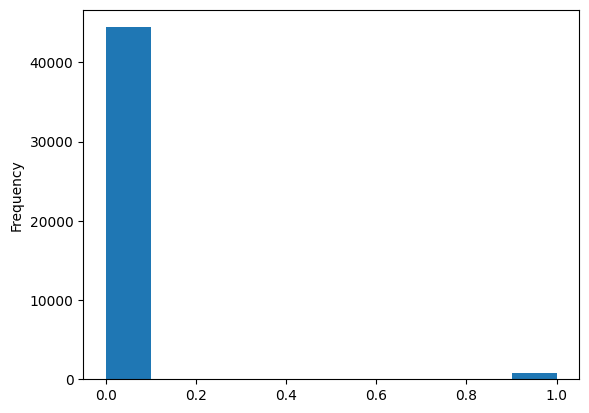

In [ ]:
# Visualize the distribution of the target
nsmo['perf_status'].plot.hist()

In [ ]:
default_pct = round((nsmo['perf_status'][nsmo['perf_status'] > 0].count() /
                     nsmo.shape[0]) * 100, 1)
print('Percentage of loans resulting in default: ' + str(default_pct) + '%')

Percentage of loans resulting in default: 1.8%


In [ ]:
# Drop the old perf_status columns
nsmo.drop(perf_status_col, axis=1, inplace=True)

### Generate the protected attribute
We generate the race attribute by combining variables X77R (Hispanic or Latino) and X78R (Race) using the following criteria:
- X78R (Race) = 1 (White only) and X77R (Hispanic or Latino) = 2 (No): W for non-Hispanic White
- X78R (Race) = 1 (White only) and X77R (Hispanic or Latino) = 1 (Yes): H for Hispanic White
- X78R (Race) = 2 (Black or African American only): B for Black
- X78R (Race) = 3 (Asian only): A for Asian
- X78R (Race) = 4 (All other races): O for Other

In [ ]:
nsmo['race'] = nsmo['x78r'].map({1: 'W', 2: 'B', 3: 'A', 4: 'O'})
nsmo['race'] = np.where((nsmo['race'] == 'W') & (nsmo['x77r'] == 1), 'H',
                        nsmo['race'])

In [ ]:
# Examine the distribution of the various racial groups
nsmo['race'].value_counts()

W    35292
H     3182
B     2746
A     2656
O     1359
Name: race, dtype: int64

In [ ]:
# Drop the old x77r and x78r columns
nsmo.drop(['x77r', 'x78r'], axis=1, inplace=True)

In [ ]:
# Create a new dataframe to track id and race
nsmo_race = nsmo[['nsmoid', 'race']]

### Generate features

In [ ]:
# NSMO X variables (multiple choice questions)
x_col = [col for col in nsmo if col.startswith('x')]
x_bool = [x for x in x_col if nsmo[x].nunique() == 2]
x_cat = [x for x in x_col if nsmo[x].nunique() > 2]
x_cat.remove('x74r') # do not category encode age

In [ ]:
# NSMO Z variables (continuous variables, but only indicating whether the
# question was answered)
z_col = [col for col in nsmo if col.startswith('z')]
z_bool = [z for z in z_col if nsmo[z].nunique() == 2]
z_cat = [z for z in z_col if nsmo[z].nunique() > 2]

In [ ]:
# Supplementary variables
supp_cont = ['open_year', 'rate_spread', 'pmms', 'term', 'ltv', 'cltv', 'dti',
             'pti', 'borrower_num', 'age_o1', 'age_o2', 'age_o3']
supp_cat = ['open_month', 'loan_amount_cat', 'loan_type', 'gse', 'metro_lmi',
            'borrower_r', 'borrower_s', 'sex_o1', 'sex_o2', 'sex_o3',
            'first_mort_r', 'first_mort_s', 'first_mort_o1', 'first_mort_o2',
            'first_mort_o3']
supp_bool = ['jumbo', 'cu']

### Drop supplemental features that are unnecessary or may cause data leakage

In [ ]:
# Drop all scoring features not available at origination
supp_scor = ['score_orig_r', 'score_orig_s', 'score_orig_o1', 'score_orig_o2',
             'score_orig_o3']
nsmo.drop(list(set([col for col in nsmo if col.startswith('score_')]).difference(
    set(supp_scor))), axis=1, inplace=True)

# Drop forbearance features
nsmo.drop([col for col in nsmo if col.startswith('forb')], axis=1, inplace=True)

# Drop mark-to-market loan-to-value ratio features
nsmo.drop([col for col in nsmo if col.startswith('mtmltv')], axis=1, inplace=True)

# Drop supplemental features only available at closing
nsmo.drop(['close_year', 'close_month', 'close_status_1222', 'cashout'], axis=1,
          inplace=True)

# Drop remaining unnecessary features
nsmo.drop(['survey_wave', 'analysis_weight'], axis=1, inplace=True)

### Encode categorical features

In [ ]:
# Label encode boolean variables
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
col_bool = x_bool + z_bool + supp_bool
for col in col_bool:
    le.fit(nsmo[col])
    nsmo[col] = le.transform(nsmo[col])

In [ ]:
# One-hot encode categorical variables
col_cat = ['race'] + x_cat + z_cat + supp_cat
for col in col_cat:
    nsmo = nsmo.join(pd.get_dummies(nsmo[col], prefix=col, prefix_sep='.'))

# Drop the old col_cat columns
nsmo.drop(col_cat, axis=1, inplace=True)

### Identify features most correlated with race (Black) and synthesize proxy variables

In [ ]:
# Find correlations among variables
corr = nsmo.corr()

In [ ]:
# List the features most positively correlated with race (Black)
corr['race.B'].sort_values(ascending=False)[:10]

race.B             1.000000
x32.1              0.124292
loan_type.2        0.120612
ltv                0.112584
cltv               0.110489
first_mort_s.-2    0.107247
x30b.1             0.105446
metro_lmi.2        0.103448
x06.1              0.102123
gse.-2             0.100339
Name: race.B, dtype: float64

In [ ]:
# List the features most negatively correlated with race (Black)
corr['race.B'].sort_values()[:10]

race.W         -0.478951
loan_type.1    -0.153877
score_orig_s   -0.114965
x30c.-2        -0.108957
x30a.-2        -0.108957
x30d.-2        -0.108957
x32.-2         -0.108957
x30b.-2        -0.108957
x31.-2         -0.108957
x29            -0.108957
Name: race.B, dtype: float64

In [ ]:
# Identify proxies by identifying all X/Z features correlated with race (Black)
# and set a cutoff value
cutoff = 0.05
proxies = list(corr.loc[(corr.index.str.startswith('x') | corr.index.str.
                         startswith('z')) & ((corr['race.B'] > cutoff) | (corr[
                            'race.B'] < -cutoff))].index)
len(proxies)

89

### Do overlap testing to identify features that may cause a positivity violation with race.
We do this by checking if there are any columns where there are no Whites who have this value, which means that the variable may act as a proxy for non-Whites. <br><br>
For this POC, we assume that just having one example is sufficient to prevent a positivity violation. In practice, we would want more examples so that the classifier has enough instances to isolate the causal and spurious effects.

In [ ]:
# Identify positivity violations
xz_col = [col for col in nsmo if col.startswith('x')] + [col for col in nsmo
                                                         if col.startswith('z')]
n_unique = nsmo[nsmo['race.W'] == 1][xz_col].nunique()
pos_viol = list(n_unique[n_unique < 2].index)

In [ ]:
# Print out number of features in the dataset that have a positivity violation
len(pos_viol)

0

In this dataset, we have no positivity violations. This means that in our counterfactual inferences, we can control for the spurious effect of race for a particular value so that only the causal effect of that value is used for prediction.<br><br>
If we had positivity violations, we would develop a rule table to replace individual values that could act as a proxy for race with another individual value. We would then apply the value replacement rules during inference.

## Model Building

### Define helper functions

In [ ]:
# Function to extract and drop specific features
def extract_features(data):
  data_id = data['nsmoid']          # Get id
  data_labels = data['perf_status'] # Get label

  # Drop id, race, and labels from dataset
  data = data.drop(['nsmoid', 'perf_status'], axis=1)

  return data, data_id, data_labels

In [ ]:
# Create the kfold object
k_fold = KFold(n_splits=5, shuffle=True, random_state=random_seeds['kfold'][0])

In [ ]:
# Function to train the model
def train_model(features_train, valid_train, labels_train, labels_valid, iter=0):
  # Create the model
  model = lgb.LGBMClassifier(n_estimators=10000, objective='binary',
                             class_weight='balanced', learning_rate=0.05,
                             reg_alpha=0.1, reg_lambda=0.1,
                             subsample=0.8, n_jobs=-1,
                             random_state=random_seeds['lgbm'][iter])

  # Train the model
  model.fit(features_train, labels_train, eval_metric='auc',
            eval_set=[(valid_train, labels_valid), (features_train,
                                                       labels_train)],
            eval_names=['valid', 'train'], categorical_feature='auto',
            callbacks=[lgb.early_stopping(100)])

  return model

In [ ]:
# Function to plot feature importance
def plot_feature_importance(df, num=15):
    # Sort features according to importance
    df = df.sort_values('importance', ascending=False).reset_index()

    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()

    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:num]))),
            df['importance_normalized'].head(num),
            align='center', edgecolor='k')

    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:num]))))
    ax.set_yticklabels(df['feature'].head(num))

    # Plot labeling
    plt.xlabel('Normalized Importance')
    plt.title('Feature Importances')
    plt.show()

### Build an awareness model that contains all features including the protected attribute

In [ ]:
# Split the data
nsmo_train_valid, nsmo_test = train_test_split(nsmo, test_size=0.20,
                                               random_state=random_seeds['split'][0])

In [ ]:
# Extract and drop features from data
nsmo_train_valid, nsmo_train_valid_id, nsmo_train_valid_labels = extract_features(nsmo_train_valid)
nsmo_test, nsmo_test_id, nsmo_test_labels = extract_features(nsmo_test)

In [ ]:
# Record features
features = nsmo_train_valid.columns

# Convert to np arrays
nsmo_train_valid = np.array(nsmo_train_valid)
nsmo_train_valid_labels = np.array(nsmo_train_valid_labels)

# Empty array for feature importances
feature_importance_values = np.zeros(nsmo_train_valid.shape[1])

# Empty array for test predictions
test_predictions = np.zeros(nsmo_test.shape[0])

In [ ]:
# Iterate through each fold
for train_indices, valid_indices in k_fold.split(nsmo_train_valid):
  # Training data for the fold
  nsmo_train = nsmo_train_valid[train_indices]
  nsmo_train_labels = nsmo_train_valid_labels[train_indices]
  # Validation data for the fold
  nsmo_valid = nsmo_train_valid[valid_indices]
  nsmo_valid_labels = nsmo_train_valid_labels[valid_indices]

  # Train the awareness model
  model = train_model(nsmo_train, nsmo_valid, nsmo_train_labels, nsmo_valid_labels)

  # Record the feature importances
  feature_importance_values += (model.feature_importances_ / k_fold.n_splits)

  # Make predictions
  test_predictions += (model.predict_proba(nsmo_test)[:, 1] / k_fold.n_splits)

[LightGBM] [Info] Number of positive: 514, number of negative: 28436
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.137284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3721
[LightGBM] [Info] Number of data points in the train set: 28950, number of used features: 988
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[112]	train's auc: 0.997604	train's binary_logloss: 0.144648	valid's auc: 0.868796	valid's binary_logloss: 0.188708
[LightGBM] [Info] Number of positive: 501, number of negative: 28449
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.118170 seconds.
You can set `force_row_wise=true` to remove the overhead.

In [ ]:
# Create a results dataframe (nsmoid, race, labels, predictions)
results = pd.concat([nsmo_test_id, nsmo_test_labels], axis=1)
results['predictions'] = test_predictions
results = pd.merge(results, nsmo_race, on='nsmoid')

In [ ]:
# Calculate ROC/AUC score for the awareness model
roc_aware = roc_auc_score(results['perf_status'], results['predictions'])
roc_aware_white = roc_auc_score(results[results['race'] == 'W'][
      'perf_status'], results[results['race'] == 'W']['predictions'])
roc_aware_black = roc_auc_score(results[results['race'] == 'B'][
      'perf_status'], results[results['race'] == 'B']['predictions'])

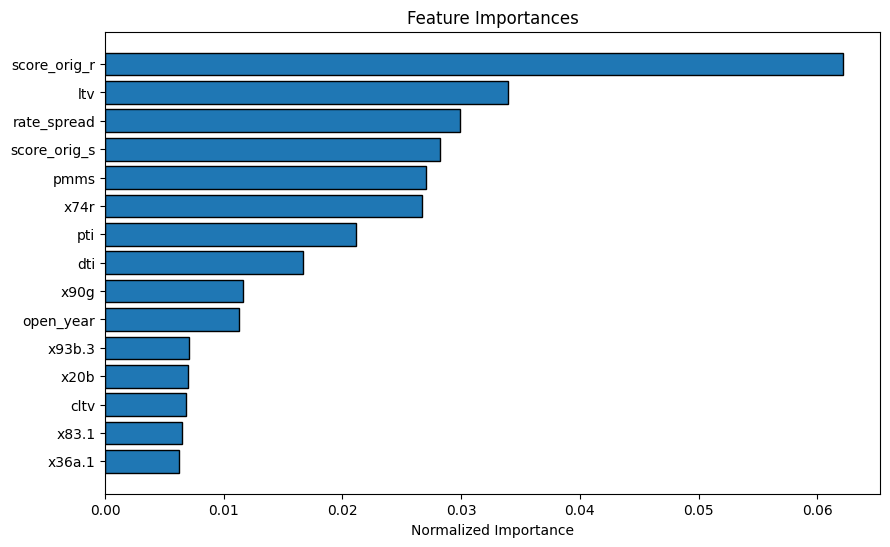

In [ ]:
# Plot most important features
fi = pd.DataFrame({'feature': list(features),
                   'importance': feature_importance_values})
plot_feature_importance(fi)

In [ ]:
# List most important features
fi.sort_values(by=['importance'], ascending=False)[:15]

,feature,importance
85,score_orig_r,194.4
76,ltv,106.0
73,rate_spread,93.4
86,score_orig_s,88.2
74,pmms,84.6
39,x74r,83.4
79,pti,66.0
78,dti,52.0
70,x90g,36.2
71,open_year,35.2


In [ ]:
# List feature importances associated with race
fi[fi['feature'].str.startswith('race')]

,feature,importance
90,race.A,4.6
91,race.B,8.8
92,race.H,2.0
93,race.O,1.2
94,race.W,2.6


In [ ]:
# Merge correlation with feature importance
feat_corr = pd.merge(fi, corr['race.B'].to_frame().reset_index().rename(columns=
  {'index': 'feature', 'race.B': 'corr_race.B'}), on='feature')

In [ ]:
# List 10 most negatively correlated features with Black
feat_corr.sort_values(by='corr_race.B').head(10)

,feature,importance,corr_race.B
94,race.W,2.6,-0.478951
971,loan_type.1,6.8,-0.153877
86,score_orig_s,88.2,-0.114965
370,x30a.-2,0.0,-0.108957
386,x31.-2,0.0,-0.108957
376,x30c.-2,0.0,-0.108957
379,x30d.-2,0.0,-0.108957
391,x32.-2,0.0,-0.108957
373,x30b.-2,0.0,-0.108957
23,x29,0.6,-0.108957


In [ ]:
# List 10 most positively correlated features with Black
feat_corr.sort_values(by='corr_race.B', ascending=False).head(10)

,feature,importance,corr_race.B
91,race.B,8.8,1.000000
392,x32.1,12.0,0.124292
972,loan_type.2,4.8,0.120612
76,ltv,106.0,0.112584
77,cltv,21.2,0.110489
999,first_mort_s.-2,0.0,0.107247
374,x30b.1,0.4,0.105446
980,metro_lmi.2,1.6,0.103448
116,x06.1,7.2,0.102123
975,gse.-2,7.6,0.100339


### Build an unawareness model that removes the protected attribute and proxies

In [ ]:
# Prepare the data by dropping race and proxies from the dataset
nsmo_unaware = nsmo.copy()
race_col = [col for col in nsmo_unaware if col.startswith('race.')]
nsmo_unaware.drop(race_col + proxies, axis=1, inplace=True)

In [ ]:
# Split the data
nsmo_train_valid, nsmo_test = train_test_split(nsmo_unaware, test_size=0.20,
                                               random_state=random_seeds['split'][0])

In [ ]:
# Extract and drop features from data
nsmo_train_valid, nsmo_train_valid_id, nsmo_train_valid_labels = extract_features(nsmo_train_valid)
nsmo_test, nsmo_test_id, nsmo_test_labels = extract_features(nsmo_test)

In [ ]:
# Record features
features = nsmo_train_valid.columns

# Convert to np arrays
nsmo_train_valid = np.array(nsmo_train_valid)
nsmo_train_valid_labels = np.array(nsmo_train_valid_labels)

# Empty array for feature importances
feature_importance_values = np.zeros(nsmo_train_valid.shape[1])

# Empty array for test predictions
test_predictions = np.zeros(nsmo_test.shape[0])

In [ ]:
# Iterate through each fold
for train_indices, valid_indices in k_fold.split(nsmo_train_valid):
  # Training data for the fold
  nsmo_train = nsmo_train_valid[train_indices]
  nsmo_train_labels = nsmo_train_valid_labels[train_indices]
  # Validation data for the fold
  nsmo_valid = nsmo_train_valid[valid_indices]
  nsmo_valid_labels = nsmo_train_valid_labels[valid_indices]

  # Train the unawareness model
  model = train_model(nsmo_train, nsmo_valid, nsmo_train_labels, nsmo_valid_labels)

  # Record the feature importances
  feature_importance_values += (model.feature_importances_ / k_fold.n_splits)

  # Make predictions
  test_predictions += (model.predict_proba(nsmo_test)[:, 1] / k_fold.n_splits)

[LightGBM] [Info] Number of positive: 514, number of negative: 28436
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.105440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3533
[LightGBM] [Info] Number of data points in the train set: 28950, number of used features: 894
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[106]	train's auc: 0.996254	train's binary_logloss: 0.158828	valid's auc: 0.868091	valid's binary_logloss: 0.201093
[LightGBM] [Info] Number of positive: 501, number of negative: 28449
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.265246 seconds.
You can set `force_row_wise=true` to remove the overhead.

In [ ]:
# Create a results dataframe (nsmoid, race, labels, predictions)
results = pd.concat([nsmo_test_id, nsmo_test_labels], axis=1)
results['predictions'] = test_predictions
results = pd.merge(results, nsmo_race, on='nsmoid')

In [ ]:
# Calculate ROC/AUC score for the unawareness model
roc_unaware = roc_auc_score(results['perf_status'], results['predictions'])
roc_unaware_white = roc_auc_score(results[results['race'] == 'W'][
      'perf_status'], results[results['race'] == 'W']['predictions'])
roc_unaware_black = roc_auc_score(results[results['race'] == 'B'][
      'perf_status'], results[results['race'] == 'B']['predictions'])

### Build two backdoor adjusted models: a counterfactual model where race is fixed (White) and a factual model with the factual race

In [ ]:
# Split the data
nsmo_train_valid, nsmo_test = train_test_split(nsmo, test_size=0.20,
                                               random_state=random_seeds['split'][0])

In [ ]:
# Extract and drop features from data
nsmo_train_valid, nsmo_train_valid_id, nsmo_train_valid_labels = extract_features(nsmo_train_valid)
nsmo_test, nsmo_test_id, nsmo_test_labels = extract_features(nsmo_test)

In [ ]:
# Record features
features = nsmo_train_valid.columns

# Convert to np arrays
nsmo_train_valid = np.array(nsmo_train_valid)
nsmo_train_valid_labels = np.array(nsmo_train_valid_labels)

# Empty array for feature importances
feature_importance_values = np.zeros(nsmo_train_valid.shape[1])

# Empty array for test predictions
test_predictions_cf = np.zeros(nsmo_test.shape[0])
test_predictions_ld = np.zeros(nsmo_test.shape[0])

In [ ]:
# Make a counterfactual nsmo_test dataset
nsmo_test_cf = nsmo_test.copy()
nsmo_test_cf[race_col] = 0
nsmo_test_cf['race.W'] = 1

In [ ]:
# Iterate through each fold
for train_indices, valid_indices in k_fold.split(nsmo_train_valid):
  # Training data for the fold
  nsmo_train = nsmo_train_valid[train_indices]
  nsmo_train_labels = nsmo_train_valid_labels[train_indices]
  # Validation data for the fold
  nsmo_valid = nsmo_train_valid[valid_indices]
  nsmo_valid_labels = nsmo_train_valid_labels[valid_indices]

  # Train the awareness model
  model = train_model(nsmo_train, nsmo_valid, nsmo_train_labels, nsmo_valid_labels)

  # Record the feature importances
  feature_importance_values += (model.feature_importances_ / k_fold.n_splits)

  # Make predictions
  pred_factual = model.predict_proba(nsmo_test)[:,1]
  pred_cf = model.predict_proba(nsmo_test_cf)[:,1]
  pred_ld = np.minimum(pred_cf, pred_factual)

  test_predictions_cf += (pred_cf / k_fold.n_splits)
  test_predictions_ld += (pred_ld / k_fold.n_splits)

[LightGBM] [Info] Number of positive: 514, number of negative: 28436
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.130524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3721
[LightGBM] [Info] Number of data points in the train set: 28950, number of used features: 988
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[112]	train's auc: 0.997604	train's binary_logloss: 0.144648	valid's auc: 0.868796	valid's binary_logloss: 0.188708
[LightGBM] [Info] Number of positive: 501, number of negative: 28449
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.125593 seconds.
You can set `force_row_wise=true` to remove the overhead.

In [ ]:
# Create a results dataframe (nsmoid, race, labels, predictions)
results = pd.concat([nsmo_test_id, nsmo_test_labels], axis=1)
results['predictions'] = test_predictions_cf
results = pd.merge(results, nsmo_race, on='nsmoid')

In [ ]:
# Calculate ROC/AUC score for the backdoor counterfactual model
roc_bd_cf = roc_auc_score(results['perf_status'], results['predictions'])
roc_bd_cf_white = roc_auc_score(results[results['race'] == 'W'][
      'perf_status'], results[results['race'] == 'W']['predictions'])
roc_bd_cf_black = roc_auc_score(results[results['race'] == 'B'][
      'perf_status'], results[results['race'] == 'B']['predictions'])

In [ ]:
# Create a results dataframe (nsmoid, race, labels, predictions)
results = pd.concat([nsmo_test_id, nsmo_test_labels], axis=1)
results['predictions'] = test_predictions_ld
results = pd.merge(results, nsmo_race, on='nsmoid')

In [ ]:
# Calculate ROC/AUC score for the backdoor less discriminatory model
roc_bd_ld = roc_auc_score(results['perf_status'], results['predictions'])
roc_bd_ld_white = roc_auc_score(results[results['race'] == 'W'][
      'perf_status'], results[results['race'] == 'W']['predictions'])
roc_bd_ld_black = roc_auc_score(results[results['race'] == 'B'][
      'perf_status'], results[results['race'] == 'B']['predictions'])

In [ ]:
# Gather ROC scores for each group
roc_score = pd.Series({'aware':roc_aware, 'unaware':roc_unaware, 'bd_cf':
                       roc_bd_cf, 'bd_ld':roc_bd_ld})
roc_score_white = pd.Series({'aware_white':roc_aware_white, 'unaware_white':
                             roc_unaware_white, 'bd_cf_white':roc_bd_cf_white,
                             'bd_ld_white':roc_bd_ld_white})
roc_score_black = pd.Series({'aware_black':roc_aware_black, 'unaware_black':
                             roc_unaware_black, 'bd_cf_black':roc_bd_cf_black,
                             'bd_ld_black':roc_bd_ld_black})

In [ ]:
roc_score

aware      0.872828
unaware    0.870351
bd_cf      0.872244
bd_ld      0.872688
dtype: float64

In [ ]:
roc_score_white

aware_white      0.861081
unaware_white    0.859594
bd_cf_white      0.861081
bd_ld_white      0.861081
dtype: float64

In [ ]:
roc_score_black

aware_black      0.854398
unaware_black    0.841037
bd_cf_black      0.854113
bd_ld_black      0.854739
dtype: float64